[[2. 3. 3. ... 3. 3. 4.]
 [0. 3. 4. ... 2. 1. 0.]
 [0. 3. 5. ... 2. 1. 0.]
 ...
 [0. 5. 2. ... 3. 0. 0.]
 [0. 5. 1. ... 4. 1. 0.]
 [5. 3. 3. ... 3. 3. 1.]]
[[ 6.91719705  0.67895535  0.80789617 ...  0.57761643  0.49157038
   3.74753964]
 [ 8.86201881  0.78803122  1.81061884 ...  0.87857872  1.71557915
   3.96956547]
 [ 8.10445845  0.4504532   1.79979496 ...  0.81038975  0.63460764
   3.90464691]
 ...
 [13.48088718  1.56998947  1.15813551 ...  4.37565049  6.60560548
   8.46904011]
 [12.4089647   3.12602433  1.2424287  ...  4.68605659  2.98935412
  10.03610944]
 [11.96283913  1.90684995  1.15868421 ...  3.81925625  5.76925161
  11.03171913]]


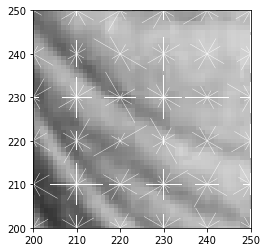

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_differential_filter():
    # To do
    filter_x = np.tile(np.array([1,0,-1]),(3,1))
    filter_y = np.tile(np.vstack(np.array([1,0,-1])),3)
    gaussian = np.array([[0,1,0],[1,2,1],[0,1,0]]) # Add the gaussian filter to mimic Park?
    return filter_x, filter_y


def filter_image(im, filter):
    # To do
    im_zero_pad = np.pad(im, ((1,1),(1,1)), 'constant')
    height,width = im_zero_pad.shape
    im_filtered = np.zeros(im.shape)
    
    for i in range(1,height-1,1):
        for j in range(1,width-1,1):
            cell = np.array([[im_zero_pad[i-1,j-1],im_zero_pad[i-1,j],im_zero_pad[i-1,j+1]],
                                [im_zero_pad[i,j-1],im_zero_pad[i,j],im_zero_pad[i,j+1]],
                                [im_zero_pad[i+1,j-1],im_zero_pad[i+1,j],im_zero_pad[i+1,j+1]]])
            
            
            im_filtered[i-1,j-1] = np.sum(cell*filter)   
    
    return im_filtered


def get_gradient(im_dx, im_dy):
    # To do
    grad_mag = np.sqrt(im_dx**2+im_dy**2)
    
    grad_angle = np.zeros(im_dx.shape)
        
    for i in range(im_dx.shape[0]):
        for j in range(im_dx.shape[1]):
            grad_angle[i,j] = np.arctan2(im_dy[i,j],im_dx[i,j])
            
        
    return grad_mag, (grad_angle+np.pi) % np.pi #将 angle 值域缩到0-180


def build_histogram(grad_mag, grad_angle, cell_size = 8):
    # To do
    angle_im = grad_angle*180/np.pi #归一至180度
    
    angle_im[np.where(angle_im>=180.0)] = 179.9 #将180°归为179.9 为了更好分类
    
    oder_im = (angle_im // 15)%11 #除以15分成 12 份 MOD 11之后 example 179//15%11 = 0.933<1
    
    for i in range(6):
        oder_im[np.where(np.logical_and(oder_im>=2*i-1, oder_im<2*i+1))] = i # 分为六类 
    
    ori_histo = np.zeros((oder_im.shape[0]//cell_size,oder_im.shape[1]//cell_size,6))
    
    for i in range(oder_im.shape[0]):
        for j in range(oder_im.shape[1]):
            #print(i//cell_size,j//cell_size,oder_im[i,j])
            oder_x = i//cell_size
            oder_y = j//cell_size
            bin_num = np.int(oder_im[i,j])
            ori_histo[oder_x,oder_y, bin_num] =grad_mag[i,j] + ori_histo[oder_x,oder_y,bin_num]
    print(oder_im)
    print(ori_histo[:,:,0])
    return ori_histo


def get_block_descriptor(ori_histo, block_size = 2):
    # To do
    eps = 0.001
    len_x = ori_histo.shape[0]-block_size+1
    len_y = ori_histo.shape[1]-block_size+1
    ori_histo_normalized = np.zeros((len_x,len_y,6,block_size,block_size))
    for i in range(len_x):
        for j in range(len_y):
            for m in range(ori_histo.shape[2]):
                 #print(ori_histo[i,j,m])
                 #H_sum = np.sqrt(np.power(ori_histo[i,j,m],2.0)+np.power(ori_histo[i,j+1,m],2.)+np.power(ori_histo[i+1,j,m],2.) +np.power(ori_histo[i+1,j+1,m],2.) + np.power(eps,2))\n",
                 #ori_histo_normalized[i,j,m,0,0] = ori_histo[i,j,m]/H_sum \n",
                 #ori_histo_normalized[i,j,m,0,1] = ori_histo[i,j+1,m]/H_sum   \n",
                 #ori_histo_normalized[i,j,m,1,0] = ori_histo[i+1,j,m]/H_sum   \n",
                 #ori_histo_normalized[i,j,m,1,1] = ori_histo[i+1,j+1,m]/H_sum   \n",
                
                H_sum = np.sqrt(np.sum(ori_histo[i:i+block_size,j:j+block_size,m]**2)+eps**2) #find sum of hi
                
                ori_histo_normalized[i,j,m,:,:] =ori_histo[i:i+block_size,j:j+block_size,m]/H_sum #do the divide
                
    ori_histo_normalized = ori_histo_normalized.reshape((len_x,len_y,6*block_size**2)) #reshape the matrix

    return ori_histo_normalized


def extract_hog(im):
    # convert grey-scale image to double format
    im = im.astype('float') / 255.0
    
    # normalized the pic
    im = im/np.max(im)
    
    # To do
    block_size = 2
    
    cell_size = 10
    
    dx,dy = get_differential_filter()
    
    im_dx = filter_image(im, dx)
    
    im_dy = filter_image(im, dy)
    
    grad_mag, grad_angle = get_gradient(im_dx, im_dy)
    
    ori_histo = build_histogram(grad_mag, grad_angle, cell_size)
    
    ori_histo_normalized =  get_block_descriptor(ori_histo, block_size)
    
    hog = ori_histo_normalized

    # visualize to verify
    visualize_hog(im, hog, cell_size, block_size)

    return hog


# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.xlim(200,250)
    plt.ylim(200,250)
    plt.show()
    


if __name__=='__main__':
    im = cv2.imread('einstein.jpg', 0)
    hog = extract_hog(im)
